In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data.dataloader import DataLoader
import torch.utils.data as data_utils
from torch.optim import lr_scheduler

import numpy as np
import numpy.linalg as LA

from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.io import savemat,loadmat
import scipy.integrate as integrate

import matplotlib.pyplot as plt

from itertools import product
from sklearn.decomposition import SparseCoder
from tqdm.notebook import tqdm,trange
import sys,time
import os
import copy
import pickle

import pysindy as ps

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Thu Aug 19 08:46:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   42C    P0    53W / 300W |    706MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   46C    P0    52W / 300W |  14915MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Discover Latent Space Dynamics

In [3]:
sample = 4
# ### Load Data if Model Already Exists ###
snapshot_full = pickle.load(open("./data/snapshot_full.p", 'rb'))
snapshot_full = snapshot_full[:,:-1].astype('float32')
snapshot_full_FOM = pickle.load(open("./data/FOM.p",'rb'))
snapshot_full_FOM = snapshot_full_FOM.astype('float32')

In [4]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

Using device: cpu 



/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /g/g15/fries4/GitHub/NM-ROM/pytorch/c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0


Sparsity in 1000 by 12024 mask: 99.70%


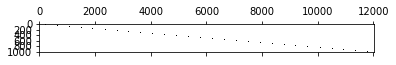

<All keys matched successfully>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('./model/AE_gauss.tar', map_location=device)    

maxk = 10
convergence_threshold = 1.0e-8

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt)

def silu(input):
    return input * torch.sigmoid(input)
class SiLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return silu(input)
    
class Encoder(nn.Module):
    def __init__(self,m,M1,f):
        super(Encoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(m,M1),
            SiLU(),
            nn.Linear(M1,f,bias=False)
        )
                
    def forward(self, y):     
        y = y.view(-1,m)
        T = self.full(y)
        T = T.squeeze()
        
        return T
    
class Decoder(nn.Module):
    def __init__(self,f,M2,m):
        super(Decoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(f,M2,bias=False),
            SiLU(),
            nn.Linear(M2,m,bias=False)
        )
             
    def forward(self,T):
        T = T.view(-1,f)
        y = self.full(T)
        y = y.squeeze()
        
        return y
m = 1000
f = 5
b = 36
db = 12
M2 = b + (m-1)*db
M1 = 2*m
 

encoder = Encoder(m,M1,f).to(device)
decoder = Decoder(f,M2,m).to(device)

def create_mask_v2(m,b,db):
    '''
    mask=create_mask_v2(m,b,db)  
    '''
    
    M2 = b + db*(m-1)
    mask = np.zeros((m,M2),dtype='int')
    
    block = np.ones(b,dtype='int')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        mask[row,col] = block
    
    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/mask.size)*100
        )
    )
    
    plt.figure()
    plt.spy(mask)
    plt.show()

    return mask

# Prune
mask = create_mask_v2(m,b,db)
prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask).to(device))    

#     optimizer = torch.optim.LBFGS(list(encoder.parameters()) + list(decoder.parameters()), lr=1)
#     scheduler = None     
# optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 

loss_func = nn.MSELoss(reduction='mean')

encoder.load_state_dict(model['encoder_state_dict'])
decoder.load_state_dict(model['decoder_state_dict'])

In [6]:
amp_arr = np.array([.7,.9])
width_arr = np.array([.9,1.1])

P = list(product(amp_arr, width_arr))
P = np.array(P)


fig = plt.figure()
ax_u = plt.axes()
ax_u.set_title('Latent Space of U')
latent_space_SS = []

ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))

colors = ['b','m','y','g','c','r']
styles = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
for foo in range(nset):
    input_SS=torch.tensor(snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].astype('float32')).to(device)
    latent_space = encoder(input_SS).cpu().detach().numpy()
#     latent_space_SS.append(latent_space)
    latent_space_SS.append(np.column_stack([latent_space,P[foo,0]*np.ones(nt+1),P[foo,1]*np.ones(nt+1)]))
    for i in range(5):
        if i == 0:
            ax_u.plot(latent_space[:,i], linestyle = styles[i], color = colors[foo])
        else:
            ax_u.plot(latent_space[:,i], linestyle = styles[i], color = colors[foo])

pickle.dump(latent_space_SS, open('./data/latent_space_SS.p', 'wb'))
plt.show()

NameError: name 'product' is not defined

In [ ]:
degree = 1
# normal = np.amax(np.abs(latent_space_SS))
normal = 1
data = list(latent_space_SS)

In [ ]:
poly_library = ps.PolynomialLibrary(include_interaction=False, degree = degree)
model_PS = ps.SINDy(feature_library = poly_library)
model_PS.fit(data, t = dt, multiple_trajectories = True)
model_PS.print()

## Test Dynamics on Training Set

In [ ]:
Max_Error = 0
for i in range(len(data)):
    X_sim = model_PS.simulate(data[i][0], t)
    Error = LA.norm((X_sim-data[i][:-1])**2/np.prod(X_sim.shape))
    if Error > Max_Error:
        Max_Error = Error
    print("MSE for Simulation {}: {}".format(i, Error))
print("")
print('Max MSE: {}'.format(Max_Error))

In [ ]:
fig = plt.figure()
fig.suptitle('Latent-Space Dynamics and Discovered Trajectory')
ax = plt.axes()

for i in [-1]:
    ax.plot(t,data[i][:-1], alpha = .5)
    plt.gca().set_prop_cycle(None)
ax.plot(t,X_sim,'--')
labels = ['Original', '_nolegend','_nolegend','_nolegend','_nolegend', 'Discovered Dynamics']
ax.legend(labels)

In [ ]:
# L = np.empty([len(data),f])
# for i in range(len(data)):
#     L[i,:] = data[i][0]

# B = LA.lstsq(P, L, rcond = None)[0].T

L = np.empty([len(data),f+2])
for i in range(len(data)):
    L[i,:] = data[i][0]

B = LA.lstsq(P, L, rcond = None)[0].T

In [ ]:
snapshot_full_FOM.shape

## Test Dynamics on FOM

In [ ]:
latent_space_FOM = encoder(torch.tensor(snapshot_full_FOM[:,:-1]).to(device))

In [ ]:
amp_arr_FOM = np.array([0.8])
width_arr_FOM = np.array([1.0])
# IC_guess = np.matmul(B, np.array([amp_arr_FOM,width_arr_FOM])).reshape(f)
IC_guess = np.matmul(B, np.array([amp_arr_FOM,width_arr_FOM])).reshape(f+2)
IC_real = latent_space_FOM[0]
# print('Initial Condition Error: {}'.format(LA.norm(IC_guess-IC_real.cpu().detach().numpy()/normal)))
IC_guess.shape

In [ ]:
latent_space_FOM_recon = torch.tensor(normal*model_PS.simulate(IC_guess, t).astype('float32')).to(device)
# FOM_recon = decoder(latent_space_FOM_recon).cpu().detach().numpy()
FOM_recon = decoder(latent_space_FOM_recon[:,:-2]).cpu().detach().numpy()
print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2,:-1])/LA.norm(snapshot_full_FOM[-2,:-1])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from SALDI')
ax.set_title('Relative Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2,:-1])/LA.norm(snapshot_full_FOM[-2,:-1])*100))
ax.plot(x[:],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon[-1],'--', label = 'SALDI')
ax.legend()

In [ ]:
FOM_re = np.empty(nt)
for i in range(nt):
    FOM_re[i] = LA.norm(FOM_recon[i]-snapshot_full_FOM[i,:-1])/LA.norm(snapshot_full_FOM[i,:-1])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via SALDI')
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')

In [ ]:
LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2,:-1])/LA.norm(snapshot_full_FOM[-2,:-1])*100

In [ ]:
snapshot_full_FOM.shape

In [ ]:
maxk = 10
convergence_threshold = 1.0e-8

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt)
# ## Functions

# In[3]:


def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def gaussian(amp,width):
    
    u0 = amp*np.exp(-(x-0.0)**2/(2*width**2))
    u0[-1] = u0[0]
    
    return u0

def residual(un,uw,c,idxn1):
    
    # r = -u^{n} + u^{n+1} -dt*f(u^{n+1})
    
    f = c*(uw**2 - uw*uw[idxn1]) 
    
    r = -un + uw + f
    
    return r

def jacobian(u,c,idxn1):

    # J = I - dt*dfdu
    
    diag_comp = 1.0 + c*(2*u - u[idxn1])
    subdiag_comp = np.ones(nx-1)
    subdiag_comp[:-1] = -c*u[1:]
        
    data = np.array([diag_comp, subdiag_comp])
    J = spdiags(data,[0,-1],nx-1,nx-1,format='csr')
    J[0,-1] = -c*u[0]
    
    return J

def solve(u0):

    u = np.zeros((nt+1,nx))
    u_inter=np.array([])
    u[0] = u0
    u_inter=np.append(u_inter,u0[:-1])
    I = sparse.eye(nx,format='csr')
    for n in range(nt): 
        uw = u[n,:-1].copy()
        r = residual(u[n,:-1],uw,c,idxn1)
        
        for k in range(maxk):
            J = jacobian(uw,c,idxn1)
            duw = spsolve(J, -r)
#             duw = np.linalg.solve(J,-r)
            uw = uw + duw
            r = residual(u[n,:-1],uw,c,idxn1)
            u_inter=np.append(u_inter,uw)

            rel_residual = np.linalg.norm(r)/np.linalg.norm(u[n,:-1])
            if rel_residual < convergence_threshold:
                u[n+1,:-1] = uw.copy()
                u[n+1,-1] = u[n+1,0]
                break
    
    return u,u_inter.reshape((-1,nx-1))

def generate_dataset(amp_arr,width_arr):
    
    num_amp=amp_arr.shape[0]
    num_width=width_arr.shape[0]
    data = []
    data_inter = []
    for i in range(num_amp):
        for j in range(num_width):
            u0=gaussian(amp_arr[i],width_arr[j])
#             u0=sine_wave(amp_arr[i],width_arr[j])
            u,u_inter=solve(u0)
            data.append(u)
            data_inter.append(u_inter)
    data = np.vstack(data)   
    data_inter = np.vstack(data_inter)   
    
    return data, data_inter

dn1=kth_diag_indices(np.eye(nx-1),-1)
idxn1=np.zeros(nx-1,dtype='int')
idxn1[1:]=np.arange(nx-2)
idxn1[0]=nx-2

In [ ]:
time_FOM_start = time.time()
snapshot_full_FOM,snapshot_full_inter_FOM = generate_dataset(amp_arr_FOM,width_arr_FOM)
time_FOM_stop = time.time()
time_FOM = time_FOM_stop-time_FOM_start
print('FOM time: {}'.format(time_FOM))

time_SINDy_start = time.time()
IC = np.matmul(B, np.array([amp_arr_FOM,width_arr_FOM])).reshape(f)
latent_space_FOM_recon = torch.tensor(model_PS.simulate(IC, t).astype('float32')).to(device)
FOM_recon = decoder(latent_space_FOM_recon).cpu().detach().numpy()
time_SINDy_stop = time.time()
time_SINDy = time_SINDy_stop-time_SINDy_start
print('SINDy time: {}'.format(time_SINDy))
print('')
print('Relative Error: {}'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-1,:-1])/LA.norm(snapshot_full_FOM[-1,:-1])))
print('')
print('Speed Up: {}'.format(time_FOM/time_SINDy))

In [ ]:
torch.cuda.empty_cache()